# Cross-validation of embedding methods

Perform cross-validation of an embedding method to tune hyperparameters and evaluate the accuracy of classifications based on Euclidean distances of embedded space.

## Analysis outline

1. Load genome sequences from a FASTA file
1. Load clade membership annotations for each genome from a separate metadata file
1. Calculate a pairwise distance matrix from the genome sequences.
1. For each fold in a *k-fold* analysis
  1. Identify sequences in the fold
  1. Subset the distance matrix to only those sequences in the fold
  1. Apply the current embedding method (e.g., MDS, t-SNE, UMAP) to the distance matrix
  1. Calculate the pairwise Euclidean distance between sequences in the embedding
  1. Calculate and store the Pearson's correlation between genetic and Euclidean distances for all pairs in the embedding
  1. Calculate and store a distance threshold below which any pair of sequences are assigned to the same clade
  1. Apply the current embeddng method to the subset of the distance matrix corresponding to the validation data for the current fold
  1. Calculate the pairwise Euclidean distance between sequences in the validation embedding
  1. Assign all pairs of sequences in the validation set to estimated "within" or "between" clade statuses based on their distances
  1. Calculate the confusion matrix from the estimated and observed clade identities
  1. Calculate and store accuracy, Matthew's correlation coefficient, etc. from the confusion matrix
1. Plot the distribution of Pearson's correlations across all *k* folds
1. Plot the distribution of accuracies, etc. across all *k* folds

In [8]:
import sys
sys.path.append("../notebooks/scripts")

## Imports

In [9]:
from augur.utils import read_node_data
import Bio.SeqIO
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
import statsmodels
import statistics
from umap import UMAP

from Helpers import get_hamming_distances, get_euclidean_data_frame, scatterplot_xyvalues

%matplotlib inline

In [207]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [208]:
def assign_clade_status_to_pairs(clade_annotations, index):
    """Assign clade status to all pairs in the given list of indices and the given data frame of clade annotations.
    
    Outputs a vector in condensed distance matrix format such that all nonredundant pairs of strains are represented.
    
    """
    clade_statuses = []
    for i in range(len(index)):
        for j in range(i + 1, len(index)):
            same_clade = clade_annotations.loc[index[i], "clade_membership"] == clade_annotations.loc[index[j], "clade_membership"]
            clade_statuses.append(int(same_clade))
            
    return np.array(clade_statuses)

## Define inputs, outputs, and parameters

In [209]:
try:
        node_df = snakemake.input.node_df,
        grid_search = snakemake.input.grid_search,
        full_visualizations = snakemake.input.full_visualizations,
        cross_v_results = snakemake.input.cross_v_results,
        cross_v_thresholds = snakemake.input.cross_v_thresholds
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# Exhaustive Grid Search and Grid Search Plot

In [17]:
df = pd.read_csv("../seasonal-flu-nextstrain-2018-2020/results/grid_search.csv", index_col=0)

In [18]:
df

,metric,perplexity,learning_rate,method,confusion_matrix,matthews_cc,threshold,accuracy,init,n_neighbors,min_dist
0,precomputed,15.0,100.0,t-SNE,[[19918 3911]\n [ 690 3447]],0.539485,-0.555556,0.835479,NaN,NaN,NaN
1,precomputed,15.0,200.0,t-SNE,[[19945 3884]\n [ 644 3493]],0.548909,-0.591592,0.838089,NaN,NaN,NaN
2,precomputed,15.0,500.0,t-SNE,[[19667 4162]\n [ 448 3689]],0.566528,-0.381381,0.835157,NaN,NaN,NaN
3,precomputed,15.0,1000.0,t-SNE,[[20711 3118]\n [ 1767 2370]],0.395150,-0.783784,0.825324,NaN,NaN,NaN
4,precomputed,30.0,100.0,t-SNE,[[17495 6334]\n [ 476 3661]],0.458670,-0.579580,0.756490,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
355,NaN,NaN,NaN,UMAP,[[19457 4316]\n [ 512 3681]],0.550155,-0.627628,0.827362,spectral,25.0,0.50
356,NaN,NaN,NaN,UMAP,[[20061 3712]\n [ 513 3680]],0.584126,-0.627628,0.848924,spectral,100.0,0.05
357,NaN,NaN,NaN,UMAP,[[20061 3712]\n [ 513 3680]],0.584126,-0.717718,0.848924,spectral,100.0,0.50
358,NaN,NaN,NaN,UMAP,[[20055 3718]\n [ 513 3680]],0.583770,-0.579580,0.848709,spectral,200.0,0.05


Text(0.5, 1.0, 'UMAP')

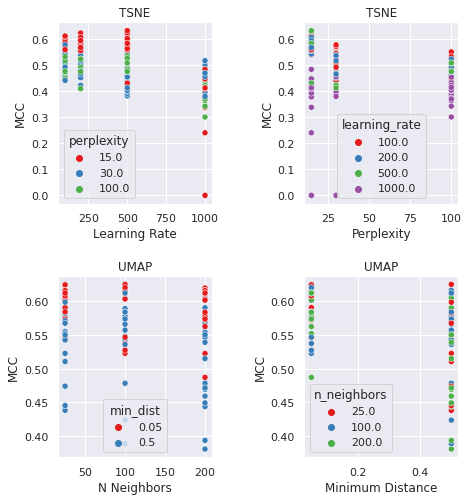

In [19]:
import matplotlib.gridspec as gridspec
sns.set_theme()
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Creates two subplots and unpacks the output array immediately
sns.scatterplot(x='learning_rate', y='matthews_cc', data=df, hue='perplexity', palette="Set1", ax=ax1)
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("MCC")
ax1.set_title('TSNE')

sns.scatterplot(x='perplexity', y='matthews_cc', data=df, hue='learning_rate', palette="Set1", ax=ax2)
ax2.set_xlabel("Perplexity")
ax2.set_ylabel("MCC")
ax2.set_title('TSNE')

sns.scatterplot(x='n_neighbors', y='matthews_cc', data=df, hue='min_dist', palette="Set1", ax=ax3)
ax3.set_xlabel("N Neighbors")
ax3.set_ylabel("MCC")
ax3.set_title("UMAP")

sns.scatterplot(x='min_dist', y='matthews_cc', data=df, hue='n_neighbors', palette="Set1", ax=ax4)
ax4.set_xlabel("Minimum Distance")
ax4.set_ylabel("MCC")
ax4.set_title("UMAP")


#plt.savefig(snakemake.output.exhaustive_grid_search)

In [ ]:
df = pd.read_csv("../seasonal-flu-nextstrain/results/full_visualizations.csv")

In [ ]:
df

In [358]:
tsne_df_1 = df[["t-SNE_x0_x", "t-SNE_y0_x", "t-SNE_x0_y", "t-SNE_y0_y", "clade_membership_x"]]

In [359]:
tsne_df_1 = tsne_df_1.dropna()
tsne_df_1.columns = ["tsne1", "tsne2", "tsne3", "tsne4", "clade_membership"]
tsne_df_1

,tsne1,tsne2,tsne3,tsne4,clade_membership
0,7.073271,35.005466,-0.741136,39.678740,3c3
1,5.514166,35.109135,-5.167346,39.627094,3c3
2,5.495962,35.108505,-5.154931,39.624172,3c3
3,5.300578,35.084164,1.195491,38.909010,3c3
4,7.198577,34.978638,1.138515,38.916904,3c3.A
...,...,...,...,...,...
953,-21.037651,-24.499954,-40.971897,-12.044399,A1b/135K
954,-44.469994,30.724863,10.801099,-5.874183,A1b/135K
955,-42.082260,15.892910,4.503805,-2.295748,A1b/135K
956,-33.378506,22.148630,-39.966454,26.241983,A1b/135K


/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Validation')

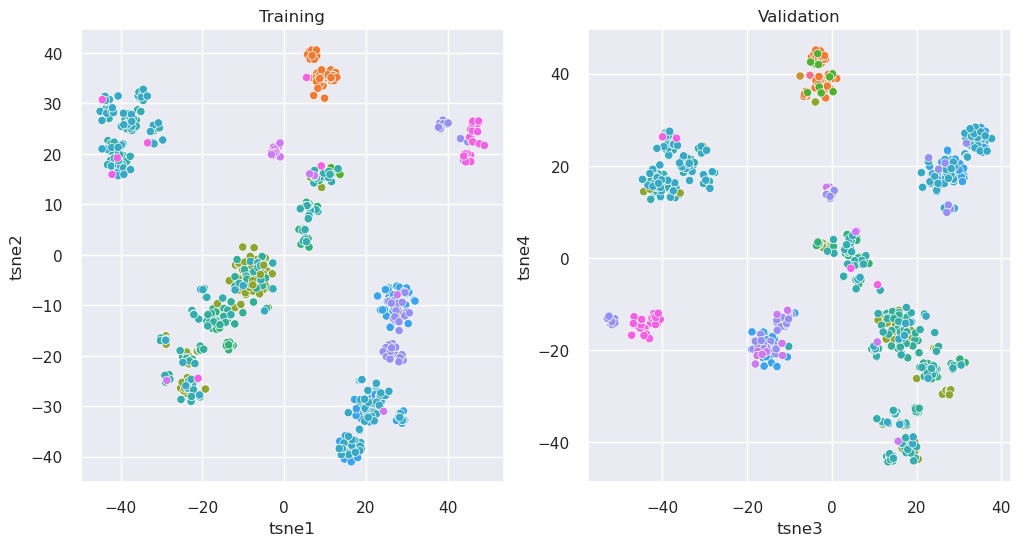

In [363]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


sns.scatterplot("tsne1", "tsne2", hue="clade_membership", data=tsne_df_1, legend=False, ax=axes[0])
axes[0].set_title("Training")

sns.scatterplot("tsne3", "tsne4", hue="clade_membership", data=tsne_df_1, legend=False, ax=axes[1])
axes[1].set_title("Validation")


In [ ]:
df = pd.read_csv("../seasonal-flu-nextstrain-2018-2020/results/grid_search.csv")

In [13]:
df_TSNE = df[df.method == 't-SNE'].dropna(axis = 1)
df_UMAP = df[df.method == 'UMAP'].dropna(axis = 1)
df_MDS = df[df.method == 'MDS'].dropna(axis = 1)

In [14]:
#perplexity: 15, learning rate: 100
TSNE_grouped = pd.DataFrame(df_TSNE.groupby(["perplexity", "learning_rate"])['matthews_cc'].mean())
TSNE_grouped.iloc[TSNE_grouped["matthews_cc"].argmax()]

matthews_cc    0.582175
Name: (15.0, 200.0), dtype: float64

In [15]:
# neighbors: 25, min_dist: .05
UMAP_grouped = pd.DataFrame(df_UMAP.groupby(["n_neighbors", "min_dist"])['matthews_cc'].mean())
val = UMAP_grouped.iloc[UMAP_grouped["matthews_cc"].argmax()]

In [16]:
val

matthews_cc    0.59302
Name: (25.0, 0.05), dtype: float64

In [376]:
cross_v_thresholds = pd.read_csv("../seasonal-flu-nextstrain/results/cross_validation_thresholds.csv")

In [340]:
cross_v_thresholds.replace({'PCA' : 'pca', 'MDS': 'mds', 't-SNE': 't-sne', "UMAP": "umap"}, inplace=True, regex=True)
#print(cross_v_thresholds)

cross_v_thresholds.loc[cross_v_thresholds['method'] == 'pca']["threshold"].values.tolist()[0]

-0.7597597597597598

In [17]:
cross_v_values = pd.read_csv("../seasonal-flu-nextstrain-2018-2020/results/full_KDE_metadata_cross_v.csv")
MCC_df = cross_v_values[["MCC", "embedding"]]

In [18]:
print(MCC_df.to_string())

     MCC embedding
0  0.587       mds
1  0.686      umap
2  0.748     t-sne
3  0.763       pca


In [2]:
cross_v_info = pd.read_csv("../seasonal-flu-nextstrain/results/cross_validation_results.csv", index_col=0)

In [24]:
cross_v_info

NameError: name 'cross_v_info' is not defined

In [14]:
import altair as alt
list_of_best =[]
for i in ['PCA', 'MDS', 't-SNE', 'UMAP']:
    df = cross_v_info[cross_v_info.method == i].dropna(how="all")
    list_of_best.append(df)
for i in range(0, 4):
    chart = alt.Chart(list_of_best[i]).mark_bar().encode(
        alt.X("threshold", bin=True),
        y='count()',
    )
    chart.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

# Final Chart for Cross Validation Analysis

In [132]:
import seaborn as sns
mpl.style.use("seaborn")

In [ ]:
## plt.scatter(x=cross_v_info["method"], y=cross_v_info["matthews_cc"])
plt.scatter(x=cross_v_info["method"], y=cross_v_info["mean"], marker="_")
plt.ylim(0, 1)
plt.show()

plt.savefig(snakemake.output.cross_v_data)